In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from finta import TA
from tqdm import tqdm

# 下載台灣加權指數資料
ticker = '^TWII'
start_date = '2022-02-26'
end_date = '2023-02-26'
df = yf.download(ticker, start=start_date, end=end_date)

# 載入模型和Scaler
model = load_model('model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 輸入股價資料,scaler,model,輸出(0,1,2)等買進賣出訊號
def process(df,scaler,model):
    df['RSI'] = TA.RSI(df)#1
    df['Williams %R'] = TA.WILLIAMS(df)#2
    df['SMA'] = TA.SMA(df)#3
    df['EMA'] = TA.EMA(df)#4
    df['WMA'] = TA.WMA(df)#5
    df['HMA'] = TA.HMA(df)#6
    df['TEMA'] = TA.TEMA(df)#7
    df['CCI'] = TA.CCI(df)#8
    df['CMO'] = TA.CMO(df)#9
    df['MACD'] = TA.MACD(df)['MACD'] - TA.MACD(df)['SIGNAL']#10
    df['PPO'] = TA.PPO(df)['PPO'] - TA.PPO(df)['SIGNAL']#11
    df['ROC'] = TA.ROC(df)#12
    df['CFI'] = TA.CFI(df)#13
    df['DMI'] = TA.DMI(df)['DI+'] - TA.DMI(df)['DI-']#14
    df['SAR'] = TA.SAR(df)#15
    df = df.dropna(axis=0)
    features = df.columns[-15:].tolist()
    Close = df[['Close']]
    df = df[features]
    # 數值轉換
    df[features] = scaler.transform(df[features])
    # 製作X
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)
    # 模型預測
    answer = model.predict(Xs)
    answer = [ np.argmax(i) for i in answer]
    
    # 繪圖
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = answer
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']
    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.show()
    
    return answer

# 回測策略
def backtest(df, model, scaler):
    # 預測結果
    signals = process(df,scaler,model)
    df = df.iloc[-len(signals):,:]
    
    # 初始資金
    capital = 1000000
    init_capital = 1000000
    # 初始股份
    stock = 0
    #報酬率序列
    total_returns_list = []
    
    # 回測主要邏輯
    for i in range(1, len(df)):
        # 如果前刻為買進狀態，而此時為賣出狀態
        if signals[i] == 2 and signals[i-1] == 1:
            # 賣出賺錢
            if stock > 0:
                capital += df['Close'][i]
                stock -= 1
        # 如果前刻為賣出狀態，而此時為買進狀態
        elif signals[i] == 1 and signals[i-1] == 2:
            # 買入股票
            if capital - df['Close'][i]>0:
                capital -= df['Close'][i]
                stock += 1

        # 計算總報酬率
        total_capital = capital + stock*df['Close'][i] #現金和股票價值合計
        total_returns = (total_capital/init_capital)*100 #總資產/初始資產*100%
        total_returns_list.append(total_returns)


    # 繪製報酬率曲線圖
    plt.plot(total_returns_list, label='TWII')
    plt.legend()
    plt.title(f'Total returns: {total_returns_list[-1]}')
    plt.show()
    return total_returns_list

[*********************100%***********************]  1 of 1 completed


100%|██████████| 190/190 [00:00<00:00, 1082.32it/s]

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 5ms/step


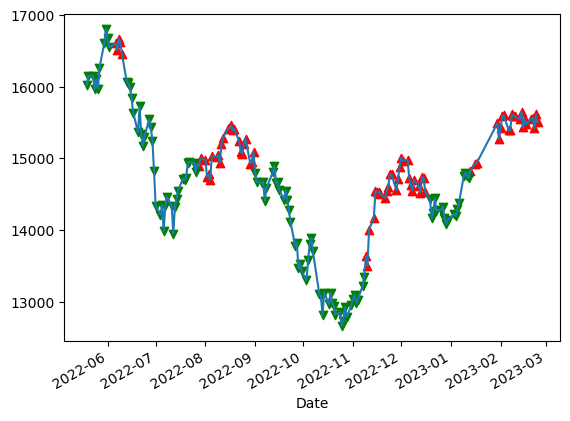

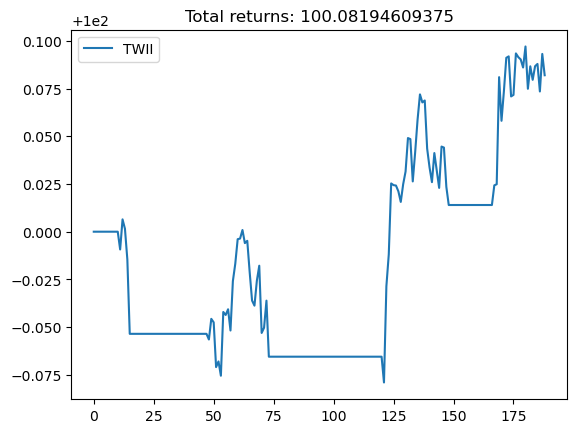

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.9906919921875,
 100.0064548828125,
 100.001537890625,
 99.9854158203125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.9435330078125,
 99.95435,
 99.95251201171875,
 99.929066015625,
 99.93204492187499,
 99.92456298828125,
 99.95794697265626,
 99.956383984375,
 99.95937099609375,
 99.948244921875,
 99.9741279296875,
 99.98323994140625,
 99.9960779296875,

In [9]:
backtest(df, model, scaler)

100%|██████████| 190/190 [00:00<00:00, 1162.34it/s]


6/6 [==============================] - 0s 4ms/step


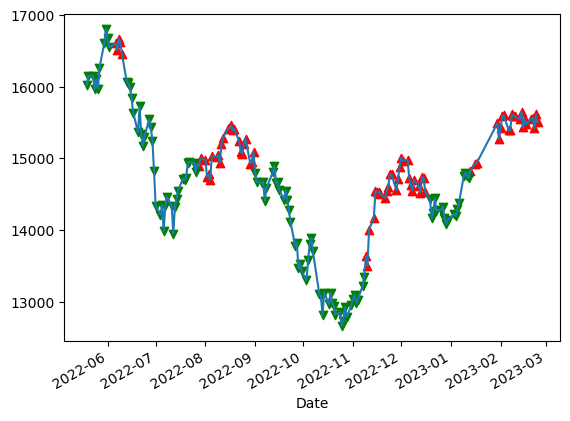

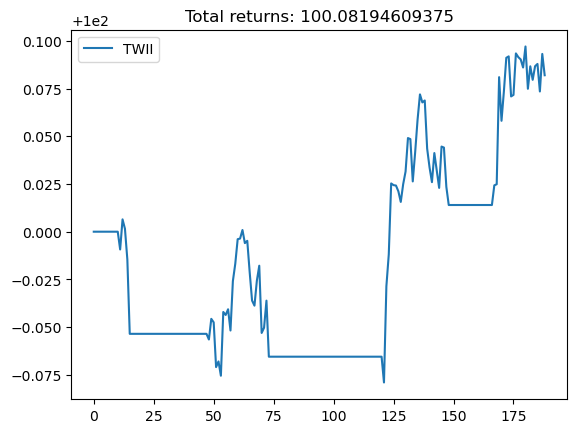

In [10]:
returns = backtest(df, model, scaler)

In [11]:
returns

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.9906919921875,
 100.0064548828125,
 100.001537890625,
 99.9854158203125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.946501953125,
 99.9435330078125,
 99.95435,
 99.95251201171875,
 99.929066015625,
 99.93204492187499,
 99.92456298828125,
 99.95794697265626,
 99.956383984375,
 99.95937099609375,
 99.948244921875,
 99.9741279296875,
 99.98323994140625,
 99.9960779296875,